In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath('../'))
from src.hopsworks_connections import pull_data, upload_data
import pandas_ta as ta
import matplotlib.pyplot as plt

# Print the current working directory
current_working_directory = os.getcwd()
print("Current Working Directory:", current_working_directory)

/Users/davydsadovskyy/GitBackedShit/crypto-prediction/venv_crypto_prediction/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current Working Directory: /Users/davydsadovskyy/GitBackedShit/crypto-prediction/notebooks


### Get a dataframe of our already manually downloaded, raw Ethereum OHLC data

In [3]:
eth_ohlc_raw = pd.read_csv('../data/raw/ohlc/ethereum.csv', parse_dates=True)
eth_ohlc_raw

,Date,Open,High,Low,Close,Volume,Volume(ETH),Market Cap
0,04/21/2024,$3153,$3191,$3120,$3146,$8.2 bn,2603957.0,$386.7 bn
1,04/20/2024,$3085,$3166,$3025,$3155,$8.9 bn,2884086.0,$377.6 bn
2,04/19/2024,$3061,$3117,$2879,$3085,$17.4 bn,5675824.0,$374.6 bn
3,04/18/2024,$2986,$3087,$2960,$3064,$13.5 bn,4453302.0,$370.6 bn
4,04/17/2024,$3083,$3119,$2926,$2984,$15.5 bn,5093979.0,$372.2 bn
...,...,...,...,...,...,...,...,...
3157,08/11/2015,$0.7081,$1.13,$0.6632,$1.07,$1.5 m,1638721.0,$53.9 m
3158,08/10/2015,$0.7140,$0.7299,$0.6365,$0.7084,$405.3 K,581293.0,$42.1 m
3159,08/09/2015,$0.7061,$0.8798,$0.6292,$0.7019,$532.2 K,729741.0,$44.1 m
3160,08/08/2015,$2.79,$2.80,$0.7147,$0.7533,$674.2 K,382082.0,$106.5 m


### Clean the raw data a bit

In [4]:
def convert_value(value):
    """
    Converts a string value to a float. Removes $ signs, and converts
    billion (bn), million (m), and thousand (K) values to their numeric equivalents.
    """
    value = value.replace('$', '')  # Remove $ sign to simplify processing
    if value[-1].lower() == 'm':
        return float(value[:-1]) * 1_000_000
    elif value[-1].lower() == 'b':
        return float(value[:-1]) * 1_000_000_000
    elif value[-1].lower() == 'k':
        return float(value[:-1]) * 1_000
    elif value[-2:].lower() == 'bn':  # Handle 'bn' for billions
        return float(value[:-2]) * 1_000_000_000
    else:
        return float(value)

eth_ohlc_raw.columns = [col.lower() for col in eth_ohlc_raw.columns]
eth_ohlc_raw.rename(columns={'volume(eth)': 'volume_eth', 'market cap': 'market_cap'}, inplace=True)

for col in ['open', 'high', 'low', 'close', 'volume', 'market_cap']:
    eth_ohlc_raw[col] = eth_ohlc_raw[col].apply(convert_value)

eth_ohlc_raw['date'] = pd.to_datetime(eth_ohlc_raw['date'])

eth_ohlc_raw

,date,open,high,low,close,volume,volume_eth,market_cap
0,2024-04-21,3153.0000,3191.0000,3120.0000,3146.0000,8.200000e+09,2603957.0,3.867000e+11
1,2024-04-20,3085.0000,3166.0000,3025.0000,3155.0000,8.900000e+09,2884086.0,3.776000e+11
2,2024-04-19,3061.0000,3117.0000,2879.0000,3085.0000,1.740000e+10,5675824.0,3.746000e+11
3,2024-04-18,2986.0000,3087.0000,2960.0000,3064.0000,1.350000e+10,4453302.0,3.706000e+11
4,2024-04-17,3083.0000,3119.0000,2926.0000,2984.0000,1.550000e+10,5093979.0,3.722000e+11
...,...,...,...,...,...,...,...,...
3157,2015-08-11,0.7081,1.1300,0.6632,1.0700,1.500000e+06,1638721.0,5.390000e+07
3158,2015-08-10,0.7140,0.7299,0.6365,0.7084,4.053000e+05,581293.0,4.210000e+07
3159,2015-08-09,0.7061,0.8798,0.6292,0.7019,5.322000e+05,729741.0,4.410000e+07
3160,2015-08-08,2.7900,2.8000,0.7147,0.7533,6.742000e+05,382082.0,1.065000e+08


## Create response variables. There will be a separate model for each eventually.

### These are binary response variables with a value of 1 if the specificied percent increase occurs between the current day's close and tomorrow's average between close and high value. They have a value of 0 if this percent increase isn't reached. When trading, it is safer to use this average than the high value because there is a higher chance that a limit order won't reach the high value.

In [5]:
transformed_df = eth_ohlc_raw.copy()
transformed_df = transformed_df.iloc[::-1].reset_index(drop=True) # reverse order

transformed_df["tmw_avg_high_close"] = (transformed_df["high"].shift(-1) + transformed_df["close"].shift(-1)) / 2
transformed_df['tmw_percent_increase'] = ((transformed_df['tmw_avg_high_close'] - transformed_df['close']) / transformed_df['tmw_avg_high_close'])

# Create binary variables for specified percent increases
for i in range(1, 11):
    threshold = i / 100
    column_name = f'tmw_{i}_percent_increase_binary'
    transformed_df[column_name] = (transformed_df['tmw_percent_increase'] >= threshold).astype(int)
    # print(transformed_df[column_name].value_counts().to_string())
    # print()

### Plot distributions of each response variable we just created

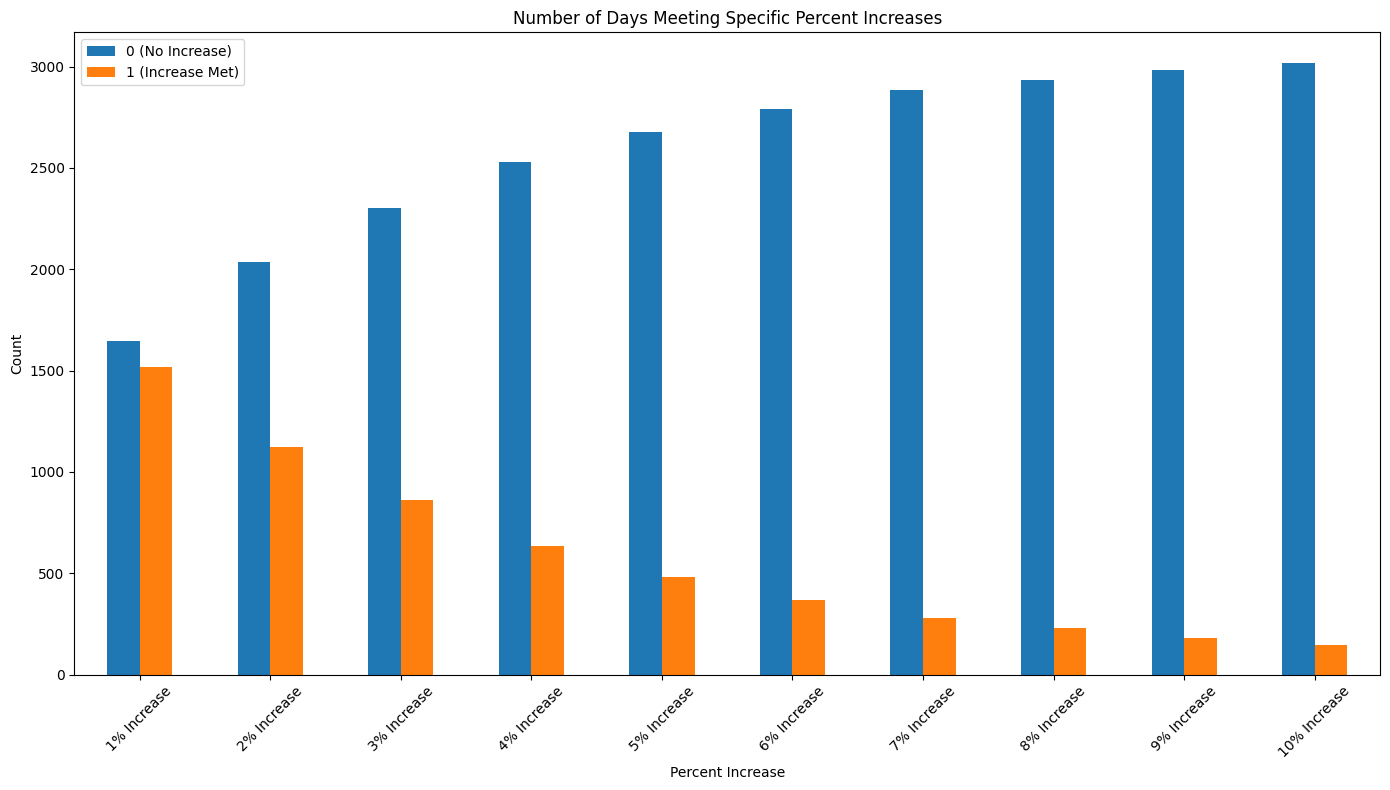

In [6]:
data = {}
for i in range(1, 11):
    column_name = f'tmw_{i}_percent_increase_binary'
    data[f'{i}% Increase'] = transformed_df[column_name].value_counts()

# Data preparation for plotting - to ensure data includes counts for both 0 and 1, even if one might be missing
plot_data = {key: [data[key].get(0, 0), data[key].get(1, 0)] for key in data}

df_plot = pd.DataFrame(plot_data, index=[0, 1])

fig, ax = plt.subplots(figsize=(14, 8))
df_plot.T.plot(kind='bar', ax=ax)
ax.set_title('Number of Days Meeting Specific Percent Increases')
ax.set_xlabel('Percent Increase')
ax.set_ylabel('Count')
ax.set_xticklabels(df_plot.columns, rotation=45)
ax.legend(["0 (No Increase)", "1 (Increase Met)"])
plt.tight_layout()
plt.show()

### We can see above that after 3% returns, the response variable class distribution is too disproportionate, which will make models less accurate. I will remove these columns, then and add in new columns that are the interval between 1 and 3.

In [7]:
# remove previous response variables
for i in range(1, 11):
    column_name = f'tmw_{i}_percent_increase_binary'
    if column_name in transformed_df.columns:
        transformed_df.drop(column_name, axis=1, inplace=True)

In [8]:
# Add in new ones response variables
intervals = [1 + i * 0.25 for i in range(int((3 - 1) / 0.25) + 1)] # 1-3, by .25
for i in intervals:
    threshold = i / 100
    column_name = f"tmw_{str(i).replace('.', '_')}_percent_increase_binary"
    transformed_df[column_name] = (transformed_df['tmw_percent_increase'] >= threshold).astype(int)

In [9]:
# Also add in a response variable of at least a 0% increase the next day. This will be like a control model in the next notebook
transformed_df['tmw_positive_percent_increase_binary'] = (transformed_df['tmw_percent_increase'] > 0).astype(int)

In [10]:
# Last row doesn't have a value for tomorrow's return, but it was assigned 0's for response variable. Convert them to NA
columns = [
    'tmw_positive_percent_increase_binary',
    'tmw_1_0_percent_increase_binary',
    'tmw_1_25_percent_increase_binary',
    'tmw_1_5_percent_increase_binary',
    'tmw_1_75_percent_increase_binary',
    'tmw_2_0_percent_increase_binary',
    'tmw_2_25_percent_increase_binary',
    'tmw_2_5_percent_increase_binary',
    'tmw_2_75_percent_increase_binary',
    'tmw_3_0_percent_increase_binary'
]

# Set the last row's specified columns to NaN
transformed_df.loc[transformed_df.index[-1], columns] = pd.NA

In [11]:
column_names = transformed_df.columns.tolist()
print(column_names)

['date', 'open', 'high', 'low', 'close', 'volume', 'volume_eth', 'market_cap', 'tmw_avg_high_close', 'tmw_percent_increase', 'tmw_1_0_percent_increase_binary', 'tmw_1_25_percent_increase_binary', 'tmw_1_5_percent_increase_binary', 'tmw_1_75_percent_increase_binary', 'tmw_2_0_percent_increase_binary', 'tmw_2_25_percent_increase_binary', 'tmw_2_5_percent_increase_binary', 'tmw_2_75_percent_increase_binary', 'tmw_3_0_percent_increase_binary', 'tmw_positive_percent_increase_binary']


## Create Predictor Variables

### Create the predictor variables that represent the current momentum of Ethereum

In [12]:
horizons = [2,5,10,25,50,100] 
predictors = []
for horizon in horizons:
    
    # Exponential Moving Average (EMA)
    ema_col = f"ema_{horizon}"
    transformed_df[ema_col] = transformed_df["close"] / ta.ema(transformed_df["close"], length=horizon)
    predictors.append(ema_col)

    # Relative Strength Index (RSI)
    rsi_col = f"rsi_{horizon}"
    transformed_df[rsi_col] = ta.rsi(transformed_df["close"], length=horizon)
    predictors.append(rsi_col)

    # Simple Moving Average (SMA)
    sma_col = f"sma_{horizon}"
    transformed_df[sma_col] = transformed_df["close"] / ta.sma(transformed_df["close"], length=horizon)
    predictors.append(sma_col)

    # Sum of the number of days in the past horizon that had a certain percent increase
    # intervals = [1 + i * 0.25 for i in range(int((3 - 1) / 0.25) + 1)] # 1-3, by .25
    for i in intervals:
        trend_col = f"last_{horizon}_day_{str(i).replace('.', '_')}_percent_increase_count"
        binary_col = f"tmw_{str(i).replace('.', '_')}_percent_increase_binary"

        if binary_col in transformed_df.columns:
            transformed_df[trend_col] = transformed_df[binary_col].shift(1).rolling(horizon).sum()
        else:
            print('FUCK')
            break

### Create predictor variables for cycles of the year and week

In [13]:
# # New Year Effect in January
# transformed_df['new_year_effect'] = (transformed_df['date'].dt.month == 1).astype(int)

# # Beginning of fiscal quarters in April and October
# transformed_df['apr_oct_fiscal_quarter_start'] = transformed_df['date'].dt.month.isin([4, 10]).astype(int)

# # Major conferences (assuming May for Consensus and October for Devcon)
# transformed_df['may_oct_major_conferences'] = transformed_df['date'].dt.month.isin([5, 10]).astype(int)

# # Summer months June to August
# transformed_df['summer_months'] = transformed_df['date'].dt.month.isin([6, 7, 8]).astype(int)

# # Reactivation of markets in September
# transformed_df['sept_market_reactivation'] = (transformed_df['date'].dt.month == 9).astype(int)

# # End of year for tax-driven trading and holiday spending in November and December
# transformed_df['nov_dec_end_of_year_activity'] = transformed_df['date'].dt.month.isin([11, 12]).astype(int)

# # Create binary columns for each month (1-12)
month_names = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']
for i in range(1, 13):  # Months are typically 1-12
    month_name = month_names[i-1]  # Get the month name from the list
    transformed_df[f'{month_name}'] = (transformed_df['date'].dt.month == i).astype(int)

# Create binary columns for each day
days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
for i, day in enumerate(days):
    transformed_df[f'{day.lower()}'] = (transformed_df['date'].dt.dayofweek == i).astype(int)

### Create some extra predictor variables using insights from '101 Formulaic Alphas' paper by Zura Kakushadze

### Remove NA rows

In [14]:
# Dropping all rows with NA, expect the last row
last_row = transformed_df.iloc[[-1]]
transformed_df = transformed_df.iloc[:-1].dropna()
transformed_df = pd.concat([transformed_df, last_row])

transformed_df

,date,open,high,low,close,volume,volume_eth,market_cap,tmw_avg_high_close,tmw_percent_increase,...,october,november,december,monday,tuesday,wednesday,thursday,friday,saturday,sunday
100,2015-11-15,0.8912,0.9215,0.8750,0.9064,4.118000e+05,458365.0,6.720000e+07,0.93685,0.032503,...,0,1,0,0,0,0,0,0,0,1
101,2015-11-16,0.9062,0.9447,0.8920,0.9290,6.209000e+05,676442.0,6.860000e+07,1.02000,0.089216,...,0,1,0,1,0,0,0,0,0,0
102,2015-11-17,0.9249,1.0300,0.9058,1.0100,1.100000e+06,1183690.0,7.220000e+07,1.00000,-0.010000,...,0,1,0,0,1,0,0,0,0,0
103,2015-11-18,0.9900,1.0100,0.9405,0.9900,6.811000e+05,691994.0,7.360000e+07,0.98275,-0.007377,...,0,1,0,0,0,1,0,0,0,0
104,2015-11-19,0.9887,1.0100,0.9375,0.9555,4.435000e+05,455866.0,7.280000e+07,0.94030,-0.016165,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3157,2024-04-17,3083.0000,3119.0000,2926.0000,2984.0000,1.550000e+10,5093979.0,3.722000e+11,3075.50000,0.029751,...,0,0,0,0,0,1,0,0,0,0
3158,2024-04-18,2986.0000,3087.0000,2960.0000,3064.0000,1.350000e+10,4453302.0,3.706000e+11,3101.00000,0.011932,...,0,0,0,0,0,0,1,0,0,0
3159,2024-04-19,3061.0000,3117.0000,2879.0000,3085.0000,1.740000e+10,5675824.0,3.746000e+11,3160.50000,0.023889,...,0,0,0,0,0,0,0,1,0,0
3160,2024-04-20,3085.0000,3166.0000,3025.0000,3155.0000,8.900000e+09,2884086.0,3.776000e+11,3168.50000,0.004261,...,0,0,0,0,0,0,0,0,1,0


### Save to .csv

In [15]:
transformed_df.to_csv('../data/transformed/ohlc/ethereum.csv', index=False)